# Interactive NLL Validation

This notebook allows for interactive validation of the Negative Log-Likelihood (NLL) function using cached results from `furax` runs.
It loads the run results (`results.npz`) and mask (`mask.npy`), reconstructs the noise operator and data, and defines the NLL function for exploration.

In [1]:
import os
import sys
from functools import partial

import healpy as hp
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from furax.obs import negative_log_likelihood
from furax.obs.operators import NoiseDiagonalOperator
from furax.obs.stokes import Stokes
from jax_healpy.clustering import get_cutout_from_mask, get_fullmap_from_cutout

# Add src to path to allow imports from furax_cs
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

import scienceplots  # noqa: F401 # pyright: ignore[reportUnusedImport]

from src.furax_cs.data.instruments import get_instrument
from src.furax_cs.r_analysis.utils import index_run_data

plt.style.use("science")

font_size = 16
plt.rcParams.update(
    {
        "font.size": font_size,
        "axes.labelsize": font_size,
        "xtick.labelsize": font_size,
        "ytick.labelsize": font_size,
        "legend.fontsize": font_size,
        "axes.titlesize": font_size,
    }
)

W0124 11:40:48.403449   86188 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0124 11:40:48.407444   85994 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


## Configuration

Set the paths to your results and mask files here. Adjust `instrument_name` and `nside` as needed.

In [50]:
# --- User Configuration ---

topk = 0.0
RESULTS_PATH_FX = f"/home/wassim/Projects/CMB/COMSEP_DATA/MINIMIZE_2/MINIMIZE/VALIDATE_FURAX/kmeans_topk{topk}_active_set_adabelief_lszoom/results.npz"  # <--- Update this path
MASK_PATH_FX = f"/home/wassim/Projects/CMB/COMSEP_DATA/MINIMIZE_2/MINIMIZE/VALIDATE_FURAX/kmeans_topk{topk}_active_set_adabelief_lszoom/mask.npy"  # <--- Update this path
BEST_PATH_FX = f"/home/wassim/Projects/CMB/COMSEP_DATA/MINIMIZE_2/MINIMIZE/VALIDATE_FURAX/kmeans_topk{topk}_active_set_adabelief_lszoom/best_params.npz"  # <--- Update this path

RESULTS_PATH_FG = "/home/wassim/Projects/CMB/COMSEP_DATA/MINIMIZE_2/MINIMIZE/VALIDATE_FG/fgbuster_c1d0s0_BD140_TD140_BS140_LiteBIRD_ALL_SUBTRACT_GALACTIC_100/results.npz"  # <--- Update this path
MASK_PATH_FG = "/home/wassim/Projects/CMB/COMSEP_DATA/MINIMIZE_2/MINIMIZE/VALIDATE_FG/fgbuster_c1d0s0_BD140_TD140_BS140_LiteBIRD_ALL_SUBTRACT_GALACTIC_100/mask.npy"  # <--- Update this path
BEST_PATH_FG = "/home/wassim/Projects/CMB/COMSEP_DATA/MINIMIZE_2/MINIMIZE/VALIDATE_FG/fgbuster_c1d0s0_BD140_TD140_BS140_LiteBIRD_ALL_SUBTRACT_GALACTIC_100/best_params.npz"  # <--- Update this path

INSTRUMENT_NAME = "LiteBIRD"
NSIDE = 64
RUN_INDEX = 0  # Which noise realization to validate (index in the results arrays)
NOISE_SELECTION = "min-value"  # 'min-value', 'min-nll', or 'idx' (int)
# --------------------------

## Load Data

Load the results, mask, and instrument configuration.

In [51]:
# Load Instrument
instrument = get_instrument(INSTRUMENT_NAME)
nu = instrument.frequency

# Load Mask
mask_arr = np.load(MASK_PATH_FX)
(mask_indices,) = np.where(mask_arr)

# Load Results
full_results_fx = dict(np.load(RESULTS_PATH_FX))
best_params_fx = dict(np.load(BEST_PATH_FX))
print(f"Loaded results from {RESULTS_PATH_FX}. Keys: {list(full_results_fx.keys())}")
full_results_fg = dict(np.load(RESULTS_PATH_FG))
best_params_fg = dict(np.load(BEST_PATH_FG))
print(f"Loaded results from {RESULTS_PATH_FG}. Keys: {list(full_results_fg.keys())}")

# Select specific run data
run_data_fx = index_run_data(full_results_fx, RUN_INDEX)
run_data_fg = index_run_data(full_results_fg, RUN_INDEX)


def select_realization(run_data, best_params, NOISE_SELECTION):
    idx = 0  # Since we already sliced by RUN_INDEX
    # Use the logic from validate.py roughly:
    if NOISE_SELECTION == "min-nll":
        idx = np.argmin(run_data["NLL"])
    elif NOISE_SELECTION == "min-value":
        idx = np.argmin(run_data["value"])
    else:
        idx = int(NOISE_SELECTION)

    # Extract parameters
    final_params = {
        "beta_dust": run_data["beta_dust"][idx]
        if run_data["beta_dust"].ndim > 1
        else run_data["beta_dust"],
        "beta_pl": run_data["beta_pl"][idx]
        if run_data["beta_pl"].ndim > 1
        else run_data["beta_pl"],
        "temp_dust": run_data["temp_dust"][idx]
        if run_data["temp_dust"].ndim > 1
        else run_data["temp_dust"],
    }

    patches = {
        "beta_dust_patches": run_data["beta_dust_patches"],
        "beta_pl_patches": run_data["beta_pl_patches"],
        "temp_dust_patches": run_data["temp_dust_patches"],
    }

    # Extract Data and Noise
    d_raw = run_data["NOISED_D"][idx] if run_data["NOISED_D"].ndim > 3 else run_data["NOISED_D"]
    n_raw = run_data["small_n"][idx] if run_data["small_n"].ndim > 3 else run_data["small_n"]
    d = best_params["I_D"]

    masked_d = Stokes.from_stokes(Q=d[:, 0], U=d[:, 1])
    noised_d = Stokes.from_stokes(Q=d_raw[0], U=d_raw[1])
    if noised_d.shape[-1] != mask_indices.size:
        noised_d = get_cutout_from_mask(noised_d, mask_indices, axis=-1)
    small_n = Stokes.from_stokes(Q=n_raw[0], U=n_raw[1])

    print("Data and parameters loaded successfully.")

    return final_params, patches, masked_d, noised_d, small_n


final_params_fx, patches_fx, masked_d_fx, noised_d_fx, small_n_fx = select_realization(
    run_data_fx, best_params_fx, NOISE_SELECTION
)
final_params_fg, patches_fg, masked_d_fg, noised_d_fg, small_n_fg = select_realization(
    run_data_fg, best_params_fg, NOISE_SELECTION
)

/home/wassim/Projects/CMB/furax-compsep-paper/src/furax_cs/data/instruments.py:41: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  return FGBusterInstrument(frequency, depth_i, depth_p)


Loaded results from /home/wassim/Projects/CMB/COMSEP_DATA/MINIMIZE_2/MINIMIZE/VALIDATE_FURAX/kmeans_topk0.0_active_set_adabelief_lszoom/results.npz. Keys: ['CMB_O', 'NLL', 'NOISED_D', 'beta_dust', 'beta_dust_patches', 'beta_pl', 'beta_pl_patches', 'iter_num', 'small_n', 'temp_dust', 'temp_dust_patches', 'value', 'W_D_FG_0']
Loaded results from /home/wassim/Projects/CMB/COMSEP_DATA/MINIMIZE_2/MINIMIZE/VALIDATE_FG/fgbuster_c1d0s0_BD140_TD140_BS140_LiteBIRD_ALL_SUBTRACT_GALACTIC_100/results.npz. Keys: ['update_history', 'value', 'CMB_O', 'NLL', 'beta_dust', 'temp_dust', 'beta_pl', 'beta_dust_patches', 'temp_dust_patches', 'beta_pl_patches', 'NOISED_D', 'small_n', 'W_D_FG_0']
Data and parameters loaded successfully.
Data and parameters loaded successfully.


## Setup NLL Function

Construct the negative log-likelihood function using the loaded data and noise operator.

In [52]:
def SNR(d, n):
    def _leaf_snr(d_channel, n_channel):
        # d_expanded is 1 , pix shape and n_channel is freq , pix shape
        # computing pixel wise SNR
        ratio = jnp.abs(d_channel) / jnp.sqrt(jnp.abs(n_channel))
        return ratio

    return jax.tree.map(_leaf_snr, d, n)


snr_stokes = SNR(noised_d_fx, small_n_fx)

snr_expand = get_fullmap_from_cutout(snr_stokes, mask_indices, NSIDE, axis=-1)

reduced_freq = jax.tree.map(
    lambda x: jnp.where(x == hp.UNSEEN, hp.UNSEEN, x.sum(axis=0)), snr_expand
)[0]

In [53]:
def expand_params(param, patches):
    patches = {
        "beta_dust": patches["beta_dust_patches"],
        "beta_pl": patches["beta_pl_patches"],
        "temp_dust": patches["temp_dust_patches"],
    }
    params_patched = jax.tree.map(lambda p, patch: p[patch], param, patches)
    params_expanded = get_fullmap_from_cutout(params_patched, mask_indices, NSIDE)
    return params_expanded


expanded_fg = expand_params(final_params_fg, patches_fg)
expanded_fx = expand_params(final_params_fx, patches_fx)

In [54]:
import equinox as eqx

(
    eqx.tree_equal(patches_fg, patches_fx),
    eqx.tree_equal(small_n_fg, small_n_fx),
    eqx.tree_equal(noised_d_fg, noised_d_fx),
)

(True, Array(True, dtype=bool), Array(True, dtype=bool))

In [55]:
from furax._instruments.sky import get_sky

pysm_sky = get_sky(64, "c1d0s0")
temp_dust_sky = pysm_sky.components[1].mbb_temperature.value

if np.isscalar(temp_dust_sky):
    temp_dust_sky = temp_dust_sky * np.ones(hp.nside2npix(64))

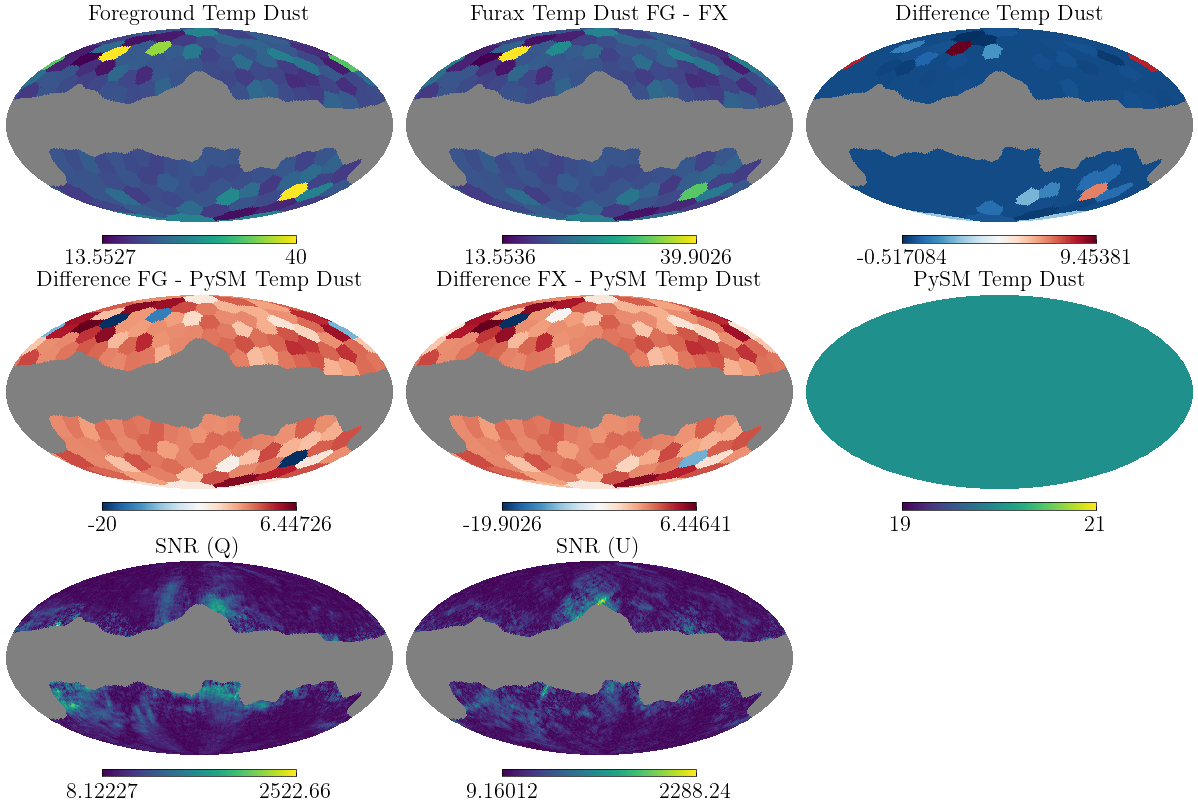

In [56]:
FG_TEMP_DUST = expanded_fg["temp_dust"]
FX_TEMP_DUST = expanded_fx["temp_dust"]
diff = np.where(FG_TEMP_DUST == hp.UNSEEN, hp.UNSEEN, FG_TEMP_DUST - FX_TEMP_DUST)
diff_fg = np.where(FG_TEMP_DUST == hp.UNSEEN, hp.UNSEEN, temp_dust_sky - FG_TEMP_DUST)
diff_fx = np.where(FX_TEMP_DUST == hp.UNSEEN, hp.UNSEEN, temp_dust_sky - FX_TEMP_DUST)

figure = plt.figure(figsize=(12, 8))
hp.mollview(FG_TEMP_DUST, title="Foreground Temp Dust", fig=figure.number, sub=(3, 3, 1))
hp.mollview(FX_TEMP_DUST, title="Furax Temp Dust FG - FX", fig=figure.number, sub=(3, 3, 2))
hp.mollview(diff, title="Difference Temp Dust", fig=figure.number, sub=(3, 3, 3), cmap="RdBu_r")
hp.mollview(
    diff_fg, title="Difference FG - PySM Temp Dust", fig=figure.number, sub=(3, 3, 4), cmap="RdBu_r"
)
hp.mollview(
    diff_fx, title="Difference FX - PySM Temp Dust", fig=figure.number, sub=(3, 3, 5), cmap="RdBu_r"
)
hp.mollview(temp_dust_sky, title="PySM Temp Dust", fig=figure.number, sub=(3, 3, 6))
hp.mollview(reduced_freq.q, title="SNR (Q)", sub=(3, 3, 7))
hp.mollview(reduced_freq.u, title="SNR (U)", sub=(3, 3, 8))
plt.show()

In [ ]:
import jax
from jax import flatten_util


def eig_hessian(nll_fn, params, **kwargs):
    """
    Computes Hessian eigenvalues using low-memory serialization.
    Instead of computing the full Hessian at once (OOM), it computes
    it row-by-row using Hessian-Vector Products.
    """

    # 1. Flatten params
    flat_params, unravel_fn = flatten_util.ravel_pytree(params)
    N_params = flat_params.size

    print(f"Computing Hessian for {N_params} parameters sequentially...")

    # 2. Define the Flat Loss Wrapper
    def flat_nll_fn(flat_p):
        p_reconstructed = unravel_fn(flat_p)
        return nll_fn(p_reconstructed, **kwargs)

    # 3. Define the HVP (Hessian-Vector Product)
    #    This computes H*v for a single vector v
    def hvp(v):
        return jax.jvp(jax.grad(flat_nll_fn), (flat_params,), (v,))[1]

    # 4. Use jax.lax.map to loop over basis vectors
    #    This is the magic step. Unlike vmap (parallel), map (serial)
    #    processes one vector at a time, keeping peak memory low.
    identity_matrix = jnp.eye(N_params)

    # This returns the full Hessian matrix (N x N)
    # It takes N times longer than a single gradient, but fits in RAM.
    H_full = jax.lax.map(hvp, identity_matrix)

    # 5. Compute Eigenvalues on the now-materialized matrix
    #    Since N=140, a dense 140x140 eigendecomposition is instant.
    print("Diagonalizing Hessian...")
    eigvals, eigvecs = jnp.linalg.eigh(H_full)

    return unravel_fn(eigvals), eigvecs

In [58]:
# Handle Cutouts

# Constants
dust_nu0 = 150.0
synchrotron_nu0 = 20.0

N_fg = NoiseDiagonalOperator(small_n_fg, _in_structure=noised_d_fg.structure)
N_fx = NoiseDiagonalOperator(small_n_fx, _in_structure=noised_d_fx.structure)

# Define NLL Function
negative_log_likelihood_fn = partial(
    negative_log_likelihood,
    dust_nu0=dust_nu0,
    synchrotron_nu0=synchrotron_nu0,
    analytical_gradient=True,
)


@jax.jit
def nll(params, d, N):
    return negative_log_likelihood_fn(
        params,
        nu=nu,
        patch_indices=patches_fg,
        d=d,
        N=N,
    )


@jax.jit
def grad_nll(params, d, N):
    return jax.grad(negative_log_likelihood_fn)(
        params,
        nu=nu,
        patch_indices=patches_fg,
        d=d,
        N=N,
    )


def eig_hessian_nll(params, d, N):
    return eig_hessian(
        nll,
        params,
        d=d,
        N=N,
    )


print("NLL and Gradient functions defined.")

NLL and Gradient functions defined.


## Evaluate NLL

Evaluate the NLL and gradient at the loaded parameters.

In [59]:
# Compute NLL
current_nll_fg = nll(final_params_fg, d=noised_d_fg, N=N_fg)
current_nll_fx = nll(final_params_fx, d=noised_d_fx, N=N_fx)
eigs_vals_fg, eig_vecs_fg = eig_hessian_nll(final_params_fg, d=noised_d_fg, N=N_fg)
eigs_vals_fx, eig_vecs_fx = eig_hessian_nll(final_params_fx, d=noised_d_fx, N=N_fx)
print(f"Current NLL FG: {current_nll_fg}")
print(f"Current NLL FX: {current_nll_fx}")
print(f"is FX lower than FG? {current_nll_fx < current_nll_fg}")

# Compute Gradient
current_grad_fg = grad_nll(final_params_fg, d=noised_d_fg, N=N_fg)
current_grad_fx = grad_nll(final_params_fx, d=noised_d_fx, N=N_fx)
grad_norms_fg = {k: jnp.linalg.norm(v) for k, v in current_grad_fg.items()}
grad_norms_fx = {k: jnp.linalg.norm(v) for k, v in current_grad_fx.items()}
print("Gradient Norms FG:", grad_norms_fg)
print("Gradient Norms FX:", grad_norms_fx)

Computing Hessian for 420 parameters sequentially...
Diagonalizing Hessian...
Computing Hessian for 420 parameters sequentially...
Diagonalizing Hessian...
Current NLL FG: -1005961402.67683
Current NLL FX: -1005961400.3028445
is FX lower than FG? False
Gradient Norms FG: {'beta_dust': Array(0.50052382, dtype=float64), 'beta_pl': Array(0.01855993, dtype=float64), 'temp_dust': Array(0.05407105, dtype=float64)}
Gradient Norms FX: {'beta_dust': Array(29.873977, dtype=float64), 'beta_pl': Array(1.8877494, dtype=float64), 'temp_dust': Array(1.04267406, dtype=float64)}


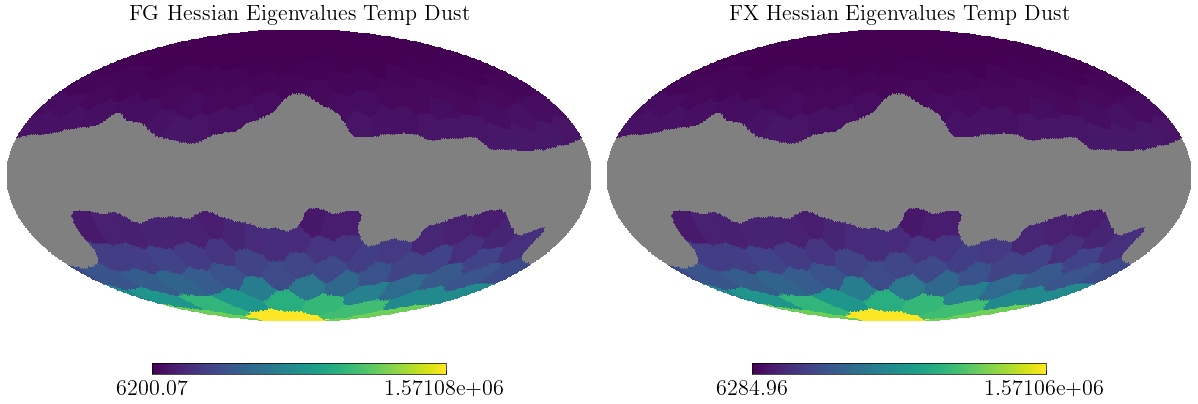

In [60]:
expanded_eigens_fg = expand_params(eigs_vals_fg, patches_fg)
expanded_eigens_fx = expand_params(eigs_vals_fx, patches_fx)

figure = plt.figure(figsize=(12, 8))
hp.mollview(
    expanded_eigens_fg["temp_dust"],
    title="FG Hessian Eigenvalues Temp Dust",
    fig=figure.number,
    sub=(1, 2, 1),
)
hp.mollview(
    expanded_eigens_fx["temp_dust"],
    title="FX Hessian Eigenvalues Temp Dust",
    fig=figure.number,
    sub=(1, 2, 2),
)
plt.show()

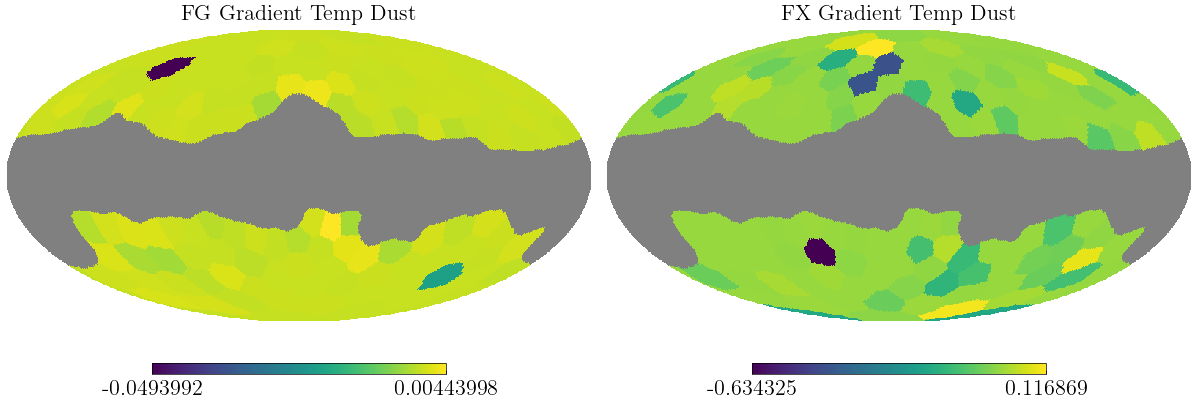

In [61]:
expand_grads_fg = expand_params(current_grad_fg, patches_fg)
expand_grads_fx = expand_params(current_grad_fx, patches_fx)

figure = plt.figure(figsize=(12, 8))
hp.mollview(
    expand_grads_fg["temp_dust"], title="FG Gradient Temp Dust", fig=figure.number, sub=(1, 2, 1)
)
hp.mollview(
    expand_grads_fx["temp_dust"], title="FX Gradient Temp Dust", fig=figure.number, sub=(1, 2, 2)
)
plt.show()

## Perturbation Analysis (Optional)

Perturb a parameter and see how the NLL changes.

In [64]:
steps

array([-10.        ,  -8.94736842,  -7.89473684,  -6.84210526,
        -5.78947368,  -4.73684211,  -3.68421053,  -2.63157895,
        -1.57894737,  -0.52631579,   0.52631579,   1.57894737,
         2.63157895,   3.68421053,   4.73684211,   5.78947368,
         6.84210526,   7.89473684,   8.94736842,  10.        ])

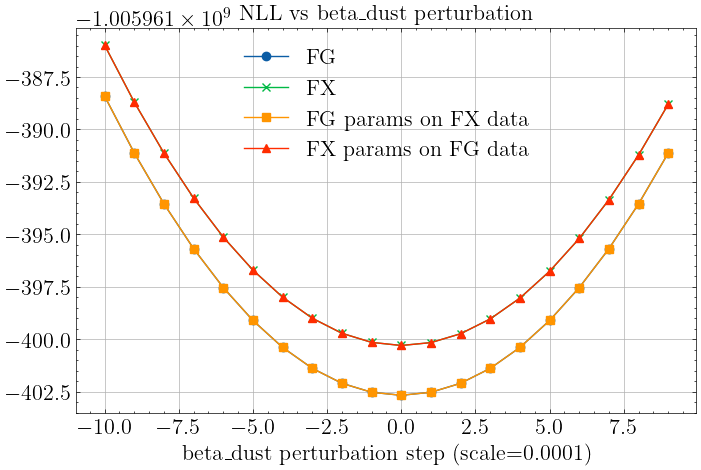

In [67]:
param_name = "beta_dust"
perturbation_scale = 0.0001
nb_steps = 20
steps = np.arange(-nb_steps // 2, nb_steps // 2)

nll_fg_values = []
nll_fx_values = []
nll_fg_fx = []
nll_fx_fg = []

for step in steps:
    perturbed_params_fg = final_params_fg.copy()
    perturbed_params_fx = final_params_fx.copy()
    # Perturb all clusters for this parameter
    perturbed_params_fg[param_name] = final_params_fg[param_name] + step * perturbation_scale
    perturbed_params_fx[param_name] = final_params_fx[param_name] + step * perturbation_scale

    val_fg_fg = nll(perturbed_params_fg, d=noised_d_fg, N=N_fg)
    val_fx_fx = nll(perturbed_params_fx, d=noised_d_fx, N=N_fx)
    val_fg_fx = nll(perturbed_params_fg, d=noised_d_fx, N=N_fx)
    val_fx_fg = nll(perturbed_params_fx, d=noised_d_fg, N=N_fg)
    nll_fg_values.append(val_fg_fg)
    nll_fx_values.append(val_fx_fx)
    nll_fg_fx.append(val_fg_fx)
    nll_fx_fg.append(val_fx_fg)

plt.figure(figsize=(8, 5))
plt.plot(steps, nll_fg_values, marker="o", label="FG")
plt.plot(steps, nll_fx_values, marker="x", label="FX")
plt.plot(steps, nll_fg_fx, marker="s", label="FG params on FX data")
plt.plot(steps, nll_fx_fg, marker="^", label="FX params on FG data")
plt.xlabel(f"{param_name} perturbation step (scale={perturbation_scale})")
plt.title(f"NLL vs {param_name} perturbation")
plt.grid(True)
plt.legend()
plt.show()